In [36]:
# Import libraries

import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from scipy.stats import chi2_contingency
import warnings

warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.3f}'.format

In [37]:
# Import data

dfBank_raw = pd.read_excel("/workspaces/logistic-regression-project-csm20/data/raw/bank_data.xlsx",sheet_name="bank_data")

In [38]:
"""
age. Age of customer (numeric)
job. Type of job (categorical)
marital. Marital status (categorical)
education. Level of education (categorical)
default. Do you currently have credit (categorical)
housing. Do you have a housing loan (categorical)
loan. Do you have a personal loan? (categorical)
contact. Type of contact communication (categorical)
month. Last month in which you have been contacted (categorical)
day_of_week. Last day on which you have been contacted (categorical)
duration. Duration of previous contact in seconds (numeric)
campaign. Number of contacts made during this campaign to the customer (numeric)
pdays. Number of days that elapsed since the last campaign until the customer was contacted (numeric)
previous. Number of contacts made during the previous campaign to the customer (numeric)
poutcome. Result of the previous marketing campaign (categorical)
emp.var.rate. Employment variation rate. Quarterly indicator (numeric)
cons.price.idx. Consumer price index. Monthly indicator (numeric)
cons.conf.idx. Consumer confidence index. Monthly indicator (numeric)
euribor3m. EURIBOR 3-month rate. Daily indicator (numeric)
nr.employed. Number of employees. Quarterly indicator (numeric)
y. TARGET. Whether the customer takes out a long-term deposit or not (categorical)
"""

dfBank_raw

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.100,"93,994.000",-36.400,"4,857.000","5,191.000",no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.100,"93,994.000",-36.400,"4,857.000","5,191.000",no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.100,"93,994.000",-36.400,"4,857.000","5,191.000",no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.100,"93,994.000",-36.400,"4,857.000","5,191.000",no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.100,"93,994.000",-36.400,"4,857.000","5,191.000",no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.100,"94,767.000",-50.800,"1,028.000","4,963.600",yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.100,"94,767.000",-50.800,"1,028.000","4,963.600",no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.100,"94,767.000",-50.800,"1,028.000","4,963.600",no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.100,"94,767.000",-50.800,"1,028.000","4,963.600",yes


In [39]:
# Data inspection

print(dfBank_raw.shape)
print(dfBank_raw.info())

# Verify duplicates and NANs

if dfBank_raw.duplicated().any().any():
    dfBank = dfBank_raw.drop_duplicates()

if dfBank_raw.isna().any().any():
    dfBank_raw = dfBank_raw.dropna()


(41188, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   411

In [ ]:
# Generate processed dataframe

dfBank_processed = dfBank_raw.select_dtypes(include=['float64', 'int64']) # Extract only numerical data

## Encoding categorical variables to make them numerically processable and include them in processed dataframe

# Encoding target

unique_target   = dfBank_raw['y'].unique() # Get list of unique jobs
target_encoding = np.array([1,2]) # Generate list to encode
target_dict     = dict(zip(unique_target, target_encoding))

dfBank_processed.insert(loc=0,column="y",value=dfBank_raw['y'].map(target_dict))

# Encoding job type

unique_jobs  = dfBank_raw['job'].unique() # Get list of unique jobs
job_encoding = np.array([1,2,3,4,5,6,7,8,9,0,10,11]) # Generate list to encode
job_dict     = dict(zip(unique_jobs,job_encoding))

dfBank_processed.insert(loc=2,column="job_encoded",value=dfBank_raw['job'].map(job_dict))

# Encoding marital status

unique_marital  = dfBank_raw['marital'].unique() # Get list of unique marital statuses
marital_encoding = np.array([1,2,3,0]) # Generate list to encode
marital_dict     = dict(zip(unique_marital,marital_encoding))

dfBank_processed.insert(loc=3,column="marital_encoded",value=dfBank_raw['marital'].map(marital_dict))

# Encoding education

unique_education  = dfBank_raw['education'].unique() # Get list of unique education level
education_encoding = np.array([2,5,3,4,6,0,7,1]) # Generate list to encode
education_dict     = dict(zip(unique_education,education_encoding))

dfBank_processed.insert(loc=4,column="education_encoded",value=dfBank_raw['education'].map(education_dict))

# Encoding default

unique_credit   = dfBank_raw['default'].unique() # Get list of unique credit status
credit_encoding = np.array([1,0,2]) # Generate list to encode
credit_dict     = dict(zip(unique_credit,credit_encoding))

dfBank_processed.insert(loc=5,column="default_encoded",value=dfBank_raw['default'].map(credit_dict))

# Encoding housing

unique_housing  = dfBank_raw['housing'].unique() # Get list of unique housing loan status
housing_encoding = np.array([1,2,0]) # Generate list to encode
housing_dict     = dict(zip(unique_housing, housing_encoding))

dfBank_processed.insert(loc=6,column="housing_encoded",value=dfBank_raw['housing'].map(housing_dict))

# Encoding loan

unique_loan  = dfBank_raw['loan'].unique() # Get list of unique personal loan status
loan_encoding = np.array([1,2,0]) # Generate list to encode
loan_dict     = dict(zip(unique_loan,loan_encoding))

dfBank_processed.insert(loc=7,column="loan_encoded",value=dfBank_raw['loan'].map(loan_dict))

# Encoding contact

unique_contact  = dfBank_raw['contact'].unique() # Get list of unique contact method
contact_encoding = np.array([1,2]) # Generate list to encode
contact_dict     = dict(zip(unique_contact,contact_encoding))

dfBank_processed.insert(loc=8,column="contact_encoded",value=dfBank_raw['contact'].map(contact_dict))

# Encoding month

unique_month  = dfBank_raw['month'].unique() # Get list of unique contact month
month_encoding = np.array([5,6,7,8,10,11,12,3,4,9]) # Generate list to encode
month_dict     = dict(zip(unique_month,month_encoding))

dfBank_processed.insert(loc=9,column="month_encoded",value=dfBank_raw['month'].map(month_dict))

# Encoding day of the week

unique_day_of_week  = dfBank_raw['day_of_week'].unique() # Get list of unique personal day_of_week status
day_of_week_encoding = np.array([1,2,3,4,5]) # Generate list to encode
day_of_week_dict     = dict(zip(unique_day_of_week,day_of_week_encoding))

dfBank_processed.insert(loc=10,column="day_of_week_encoded",value=dfBank_raw['day_of_week'].map(day_of_week_dict))

,y,age,job_encoded,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded,contact_encoded,month_encoded,day_of_week_encoded,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1,56,1,1,2,1,1,1,1,5,1,261,1,999,0,1.100,"93,994.000",-36.400,"4,857.000","5,191.000"
1,1,57,2,1,5,0,1,1,1,5,1,149,1,999,0,1.100,"93,994.000",-36.400,"4,857.000","5,191.000"
2,1,37,2,1,5,1,2,1,1,5,1,226,1,999,0,1.100,"93,994.000",-36.400,"4,857.000","5,191.000"
3,1,40,3,1,3,1,1,1,1,5,1,151,1,999,0,1.100,"93,994.000",-36.400,"4,857.000","5,191.000"
4,1,56,2,1,5,1,1,2,1,5,1,307,1,999,0,1.100,"93,994.000",-36.400,"4,857.000","5,191.000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,2,73,6,1,6,1,2,1,2,11,5,334,1,999,0,-1.100,"94,767.000",-50.800,"1,028.000","4,963.600"
41184,1,46,4,1,6,1,1,1,2,11,5,383,1,999,0,-1.100,"94,767.000",-50.800,"1,028.000","4,963.600"
41185,1,56,6,1,7,1,2,1,2,11,5,189,2,999,0,-1.100,"94,767.000",-50.800,"1,028.000","4,963.600"
41186,2,44,5,1,6,1,1,1,2,11,5,442,1,999,0,-1.100,"94,767.000",-50.800,"1,028.000","4,963.600"


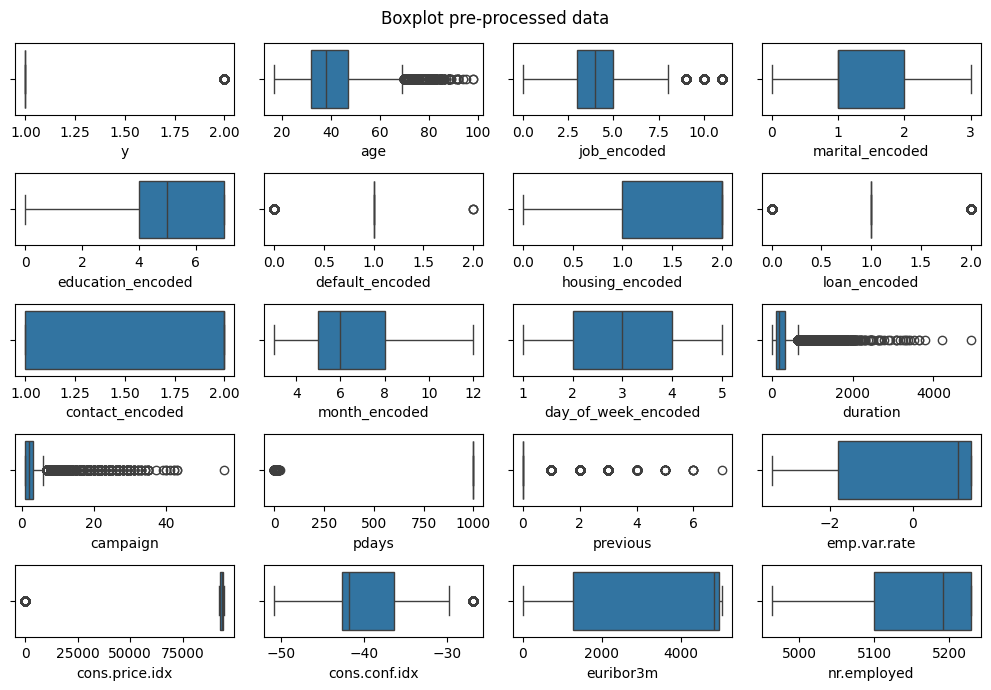

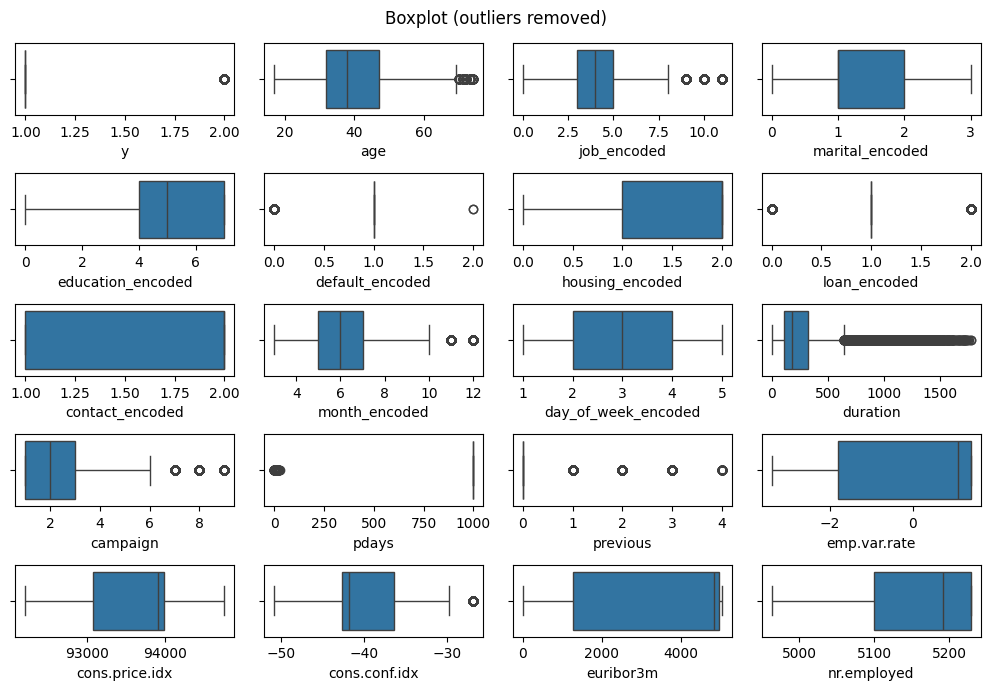

In [42]:
# Exploratory data analysis

# Get outliers
fig, axis = plt.subplots(5,4,figsize=(10,7))
r = 0
c = 0
for dfcol in dfBank_processed.columns:
    sn.boxplot(ax=axis[r,c], data = dfBank_processed, x = dfcol)
    c += 1
    if c > 3:
        r += 1
        c = 0

plt.suptitle('Boxplot pre-processed data')
plt.tight_layout()

# Remove some of the outliers

dfBank_processed = dfBank_processed[dfBank_processed['campaign'] < 10]
dfBank_processed = dfBank_processed[dfBank_processed['duration'] < 1800]
dfBank_processed = dfBank_processed[dfBank_processed['cons.price.idx'] > 25000]
dfBank_processed = dfBank_processed[dfBank_processed['age'] < 75]
dfBank_processed = dfBank_processed[dfBank_processed['previous'] <= 4]


# Get outliers
fig, axis = plt.subplots(5,4,figsize=(10,7))
r = 0
c = 0
for dfcol in dfBank_processed.columns:
    sn.boxplot(ax=axis[r,c], data = dfBank_processed, x = dfcol)
    c += 1
    if c > 3:
        r += 1
        c = 0

plt.suptitle('Boxplot (outliers removed)')
plt.tight_layout()


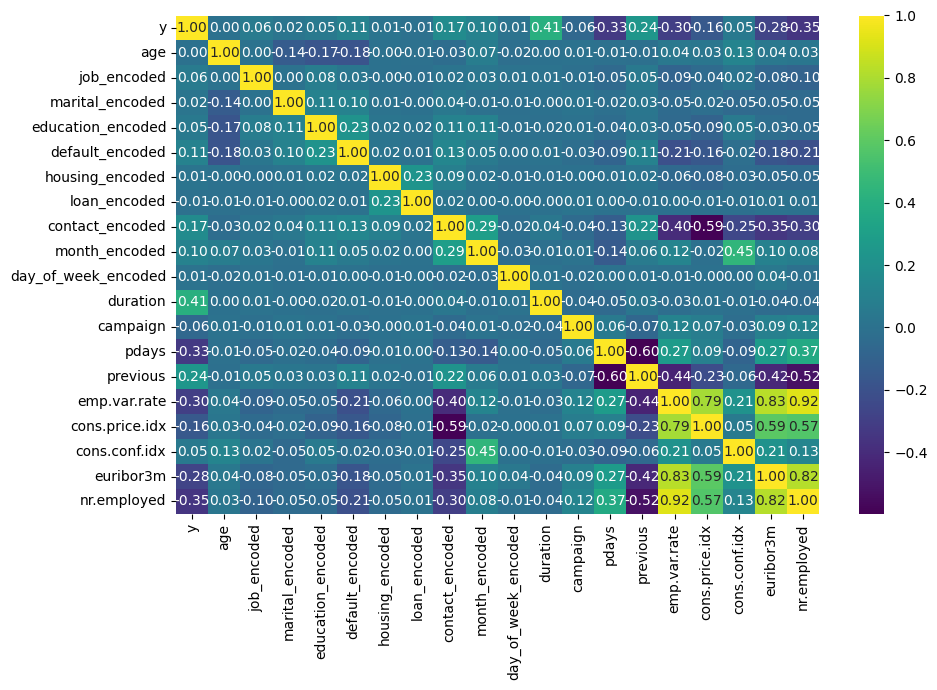

In [43]:
# Get correlation matrix

fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(dfBank_processed.corr(method="pearson"), annot=True, fmt=".2f", cmap="viridis", ax=ax)
plt.tight_layout()
plt.show()


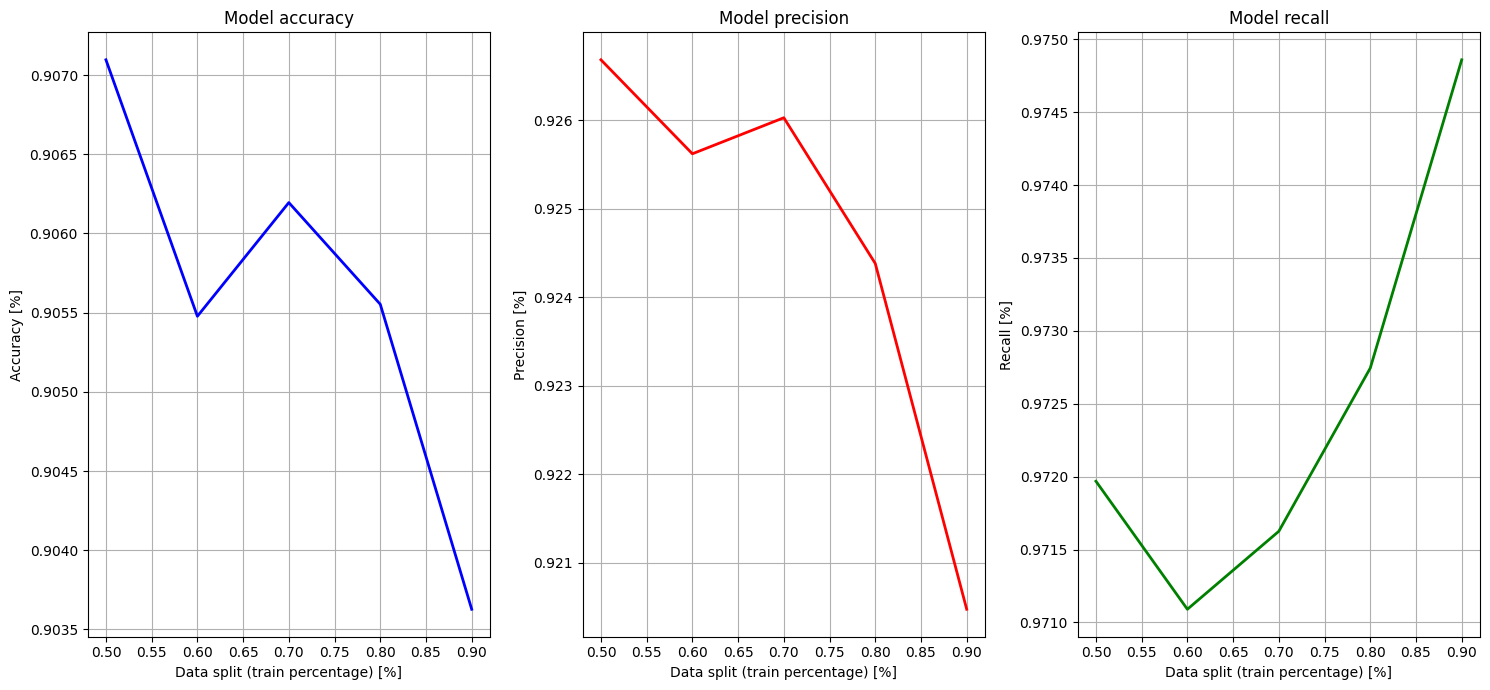

In [44]:
# # Exclusion of independent variables based on the correlation matrix

features = ['contact_encoded','duration','pdays','nr.employed']

# # The variables 'previous', 'emp.var.rate', 'euribor' have good correlation with the prediction variable y (target) but also exhibit
# # high correlation with the variables 'pdays' and 'nr.employed', so they were left out to avoid overfitting

target   = 'y'

# Set up the data

X = dfBank_processed[features]
y = dfBank_processed[target]

# To test best split trade-off we loop over different splitting ratios

accuracy  = []
precision = []
recall    = []


for split_ratio in np.arange(0.5,1,0.1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = split_ratio)

    # Logistic regression

    bank_model = LogisticRegression(solver='lbfgs',C = 1,max_iter=500)
    bank_model.fit(X_train, y_train)

    # Perform prediction
    y_pred = bank_model.predict(X_test)

    # Compute accuracy, precision, and recall
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))

# Plot split vs. scores

fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(15,7))

ax0.plot(np.arange(0.5,1,0.1),accuracy,color='blue',linewidth=2)
ax0.grid()
ax0.set_xlabel("Data split (train percentage) [%]")
ax0.set_ylabel("Accuracy [%]")
ax0.set_title("Model accuracy")
ax1.plot(np.arange(0.5,1,0.1),precision,color='red',linewidth=2)
ax1.grid()
ax1.set_xlabel("Data split (train percentage) [%]")
ax1.set_ylabel("Precision [%]")
ax1.set_title("Model precision")
ax2.plot(np.arange(0.5,1,0.1),recall,color='green',linewidth=2)
ax2.grid()
ax2.set_xlabel("Data split (train percentage) [%]")
ax2.set_ylabel("Recall [%]")
ax2.set_title("Model recall")

plt.tight_layout()

The best data split percentage is 75%, which gives the best trade-off between accuracy, precision and recall. This split percentage impoverishes ever so slightly the accuracy and precision with respect to the initial 50% but improves the recall (sensitivity) beyond of the initial recall value at 50%.

The accuracy score of the model is: 0.9063815643695989

The precision score of the model is: 0.9251724958363075

The recall score of the model is: 0.9729763543100213


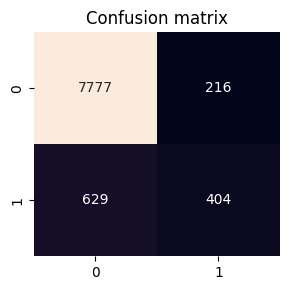

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.75)

# Logistic regression

bank_model = LogisticRegression(solver='lbfgs',C = 1,max_iter=500)
bank_model.fit(X_train, y_train)

# Perform prediction
y_pred = bank_model.predict(X_test)

print(f'The accuracy score of the model is: {accuracy_score(y_test, y_pred)}\n')
print(f'The precision score of the model is: {precision_score(y_test, y_pred)}\n')
print(f'The recall score of the model is: {recall_score(y_test, y_pred)}')

# Confusion matrix

dfBank_cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(dfBank_cm)

plt.figure(figsize = (3, 3))
sn.heatmap(cm_df, annot=True, fmt="d", cbar=False)
plt.title('Confusion matrix')
plt.tight_layout()
plt.show()

The prediction model is fairly good in recognizing and predicting which clients will sign up for a long-term deposit with an accuracy of roughly 90%. The precision is slightly higher up to 92%, so 92% of all clients with long-term deposits are correctly classified, while the recall is 97%, so very high sensitivity is achieved.

In [ ]:
# Hyperparameter optimization

hyperparams = {
    "C": [0.1, 1, 10, 100, 1000],
    "l1_ratio": [1, 0, 0.5, None],
    "solver": ["newton-cg", "lbfgs", "sag", "saga"],
    "max_iter": [500]
}

# We initialize the grid
grid = GridSearchCV(bank_model, hyperparams, scoring = "accuracy", cv = 5)
grid.fit(X_train, y_train)

# Get best parameters
print(f"Best hyperparameters: {grid.best_params_}")

# Test best hyperparameter combination

bank_model_grid = LogisticRegression(**grid.best_params_)
bank_model_grid.fit(X_train, y_train)
y_pred = bank_model_grid.predict(X_test)

grid_accuracy = accuracy_score(y_test, y_pred)
grid_accuracy

Best hyperparameters: {'C': 1, 'l1_ratio': 0, 'max_iter': 500, 'solver': 'lbfgs'}


0.9063815643695989